In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

pd.set_option('display.max_colwidth', 1000)

In [2]:
dfdesc = pd.read_csv('datafull.csv', usecols=['itemid', 'description'])

In [3]:
df = pd.read_csv('data.csv', index_col=0)
df.shape

/tmp/ipykernel_38765/363772746.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv', index_col=0)


(68952, 32)

In [4]:
df1 = df[['itemid','product_name', 'fe_category0', 'fe_category1', 'fe_category2']]

In [5]:
df2 = df1.merge(dfdesc, on='itemid')

In [6]:
train_df = df2[['description', 'fe_category0']]
train_df.columns  = ['description', 'product_category']

In [7]:
train_df = train_df.fillna(' ')

In [8]:
train_df.product_category.value_counts()

product_category
Sports & Outdoor          54890
Games, Books & Hobbies     6358
Automotive                 2814
Baby & Toys                1838
Home & Living              1686
Fashion Accessories        1388
Men Clothes                 797
Health & Beauty             723
Mobile & Accessories        588
Computer & Accessories      412
Groceries & Pets            341
Home Appliances             275
Women Clothes               201
Cameras & Drones            178
Watches                     122
Men Shoes                   101
Women's Bags                 81
Muslim Fashion               74
Travel & Luggage             63
Gaming & Consoles            59
Men's Bags & Wallets         46
Women Shoes                  15
Tickets & Vouchers            7
Others                        3
Name: count, dtype: int64

In [9]:
train_df['category_id'] = train_df['product_category'].factorize()[0]


In [10]:
train_df_sample = train_df.sample(10000, random_state=1).copy()

In [11]:
category_id_df = train_df_sample[['product_category', 'category_id']].drop_duplicates()
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'product_category']].values)

In [12]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                       ngram_range=(1, 2),
                       stop_words='english')

features = tfidf.fit_transform(train_df_sample.description).toarray()
labels = train_df_sample.category_id
print(features.shape)

(10000, 31263)


In [13]:
# Finding the three most correlated terms with each of the product categories
N = 3
for product_category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(product_category))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Automotive:
  * Most Correlated Unigrams are: visor, car, motorcycle
  * Most Correlated Bigrams are: brand italy, visor included, color visor

==> Baby & Toys:
  * Most Correlated Unigrams are: kids, walker, baby
  * Most Correlated Bigrams are: length 21, 0cm size, 5cm size

==> Cameras & Drones:
  * Most Correlated Unigrams are: volt, 84g, camera
  * Most Correlated Bigrams are: model type, toys model, rc toys

==> Computer & Accessories:
  * Most Correlated Unigrams are: ram, gpu, cpu
  * Most Correlated Bigrams are: power cable, cooling fan, graphics card

==> Fashion Accessories:
  * Most Correlated Unigrams are: party, necklace, jewelry
  * Most Correlated Bigrams are: necklace note, 2cm errors, errors manual

==> Games, Books & Hobbies:
  * Most Correlated Unigrams are: deck, playing, cards
  * Most Correlated Bigrams are: card company, playing card, playing cards

==> Gaming & Consoles:
  * Most Correlated Unigrams are: game, fighting, console
  * Most Correlated Bigrams 

In [14]:
X = train_df_sample['description'] # Collection of documents
y = train_df_sample['product_category'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [15]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.


In [16]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.8974,0.005237
LogisticRegression,0.8624,0.003130
MultinomialNB,0.8355,0.003391
RandomForestClassifier,0.7729,0.001851


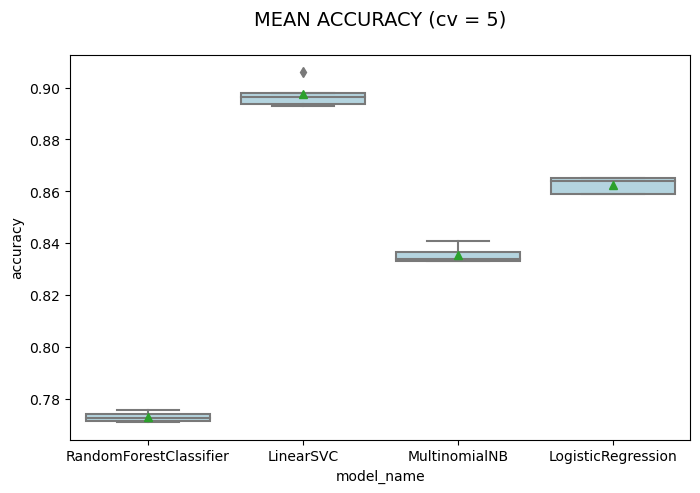

In [17]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [23]:


X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               train_df_sample.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



In [24]:


# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= train_df_sample['product_category'].unique()))



				CLASSIFICATIION METRICS



ValueError: Number of classes, 21, does not match size of target_names, 23. Try specifying the labels parameter